In [137]:
from google.colab import drive
import os
drive.mount('/content/drive/', force_remount=False)

#put the path to the directory with .csv files and 'images' folder on your google drive
datapath = '/content/drive/My Drive/ai-side-projects/road_segmentation/cityscapes_data/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Loading  [Cityscapes Image Pairs](https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/data#) kaggle dataset, [source](https://www.cityscapes-dataset.com)

Parts of code are from my projects or [this notebook](https://www.kaggle.com/code/tr1gg3rtrash/car-driving-segmentation-unet-from-scratch/notebook), or standatd tutorials.

My goal is to make a road detection network.

In [138]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
import cv2


# Data preparation and road mask selection

## Road mask with color filtering


Original segmentation map is not very useful since it has different possible colors for a given class (e.g. `road` is marked with magenta, but  do **not** have a constant color code).

Initial approach is to select a possible range of colors of `road` class colors and make a mask from it, but it is very noisy (see the first mask below).

I opted to smooth the mask image first and then make a magenta color mask and the image is smoother.  The resulted mask is much more continuous, but edge effects can be seen. So far I ignore it.

In [139]:
def filter_road_colors(img):
  # Define the range of RGB values for roads
  road_color_lower = np.array([110, 50, 120])
  road_color_upper = np.array([130, 70, 130])

  road_mask = np.all((img >= road_color_lower) & (img <= road_color_upper), axis=-1)

  road_mask = road_mask.astype(np.uint8) * 255

  return road_mask


def preprocess(path, smoothing_scale = 10, resize = 128):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256))
    img2 = img.crop((256, 0, 512, 256))
    if resize:
      img1 = img1.resize((resize,resize))
      img2 = img2.resize((resize,resize))

    img1 = np.array(img1) / 255.
    img2 = np.array(img2)

    mask2 = filter_road_colors(img2)

    if smoothing_scale:
      kernel = np.ones((smoothing_scale,smoothing_scale),np.float32)/smoothing_scale**2
      img2_smoothed = cv2.filter2D(img2,-1,kernel)
      mask2_smoothed = filter_road_colors(img2_smoothed)
    else:
      img2_smoothed = img2
      mask2_smoothed = mask2

    return img1, img2, mask2, mask2_smoothed

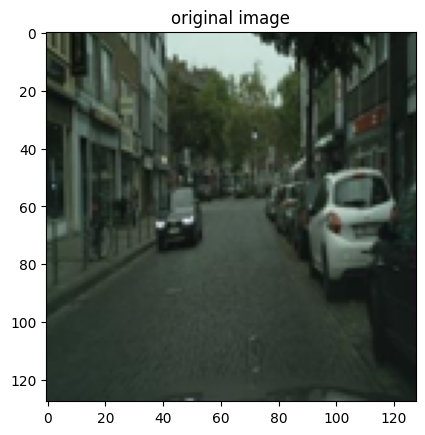

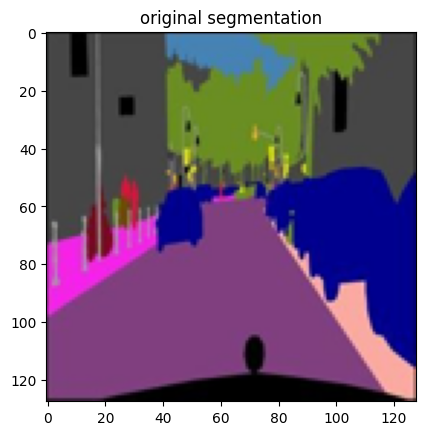

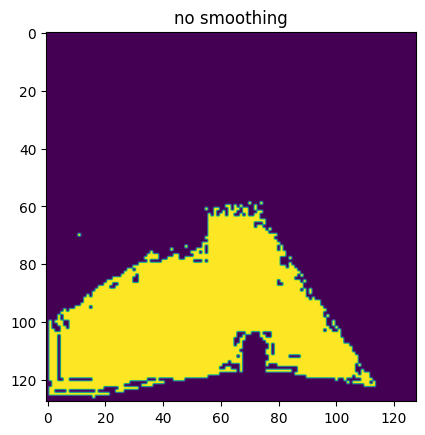

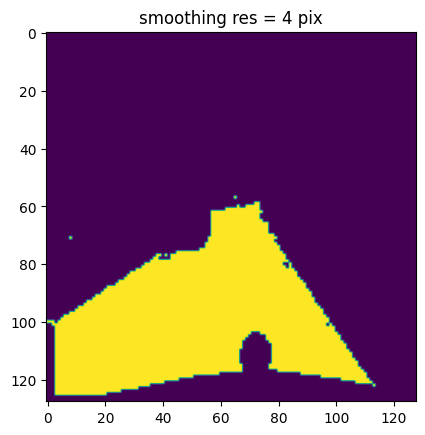

In [140]:
smooth_scale = 4
resize = 128
img1, img2, mask2, mask2_smoothed = preprocess(datapath+'train/100.jpg', smoothing_scale=smooth_scale, resize = resize)

plt.figure()
plt.imshow(img1)
plt.title('original image')
plt.figure()
plt.imshow(img2)
plt.title('original segmentation')


plt.figure()
plt.imshow(mask2)
plt.title('no smoothing')
plt.figure()
plt.title(f'smoothing res = {smooth_scale} pix')
plt.imshow(mask2_smoothed)




# Data loaders

In [148]:
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import cv2
from PIL import Image

class ImageData(Dataset):
    def __init__(self, file_paths, resize=128, smooth=4):
        self.file_paths = file_paths
        self.resize = resize
        self.smooth = smooth

    def __len__(self):
        return len(self.file_paths)

    def filter_road_colors(self, img):
        # Define the range of RGB values for roads
        road_color_lower = np.array([110, 50, 120])
        road_color_upper = np.array([130, 70, 130])

        road_mask = np.all((img >= road_color_lower) & (img <= road_color_upper), axis=-1)

        road_mask = road_mask.astype(np.uint8)

        return road_mask

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        img = Image.open(file_path)
        img1 = img.crop((0, 0, 256, 256))
        img2 = img.crop((256, 0, 512, 256))

        if self.resize:
            img1 = img1.resize((self.resize, self.resize))
            img2 = img2.resize((self.resize, self.resize))

        img1 = np.array(img1) / 255.
        img2 = np.array(img2)

        mask = self.filter_road_colors(img2)

        if self.smooth:
            kernel = np.ones((self.smooth, self.smooth), np.float32) / self.smooth ** 2
            img2_smoothed = cv2.filter2D(img2, -1, kernel)
            mask_smoothed = self.filter_road_colors(img2_smoothed)
        else:
            img2_smoothed = img2
            mask_smoothed = mask

        return img1, mask_smoothed
        #return img1.to(torch(float)), mask_smoothed.to(torch(float))

# Assuming you have lists of file paths for training and validation sets
train_file_paths = [os.path.join(datapath, 'train', filename) for filename in os.listdir(os.path.join(datapath, 'train'))]
val_file_paths = [os.path.join(datapath, 'val', filename) for filename in os.listdir(os.path.join(datapath, 'val'))]



RESIZE = 128
SMOOTH = 4
BATCH_SIZE = 5



# Create datasets
train_dataset = ImageData(train_file_paths, resize = RESIZE, smooth = SMOOTH)
val_dataset = ImageData(val_file_paths, resize = RESIZE, smooth = SMOOTH)

# You can create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

train_loader_iter = iter(train_loader)
val_loader_iter = iter(val_loader)


In [149]:
next(train_loader_iter)

[tensor([[[[0.1686, 0.2353, 0.1961],
           [0.1647, 0.2314, 0.1922],
           [0.1412, 0.2039, 0.1647],
           ...,
           [0.0471, 0.0706, 0.0549],
           [0.0706, 0.0941, 0.0784],
           [0.0627, 0.0902, 0.0588]],
 
          [[0.1529, 0.2275, 0.1882],
           [0.2118, 0.2784, 0.2392],
           [0.1961, 0.2588, 0.2235],
           ...,
           [0.0627, 0.0863, 0.0706],
           [0.0706, 0.0941, 0.0784],
           [0.0549, 0.0863, 0.0431]],
 
          [[0.1961, 0.2745, 0.2314],
           [0.1961, 0.2745, 0.2314],
           [0.2235, 0.2902, 0.2510],
           ...,
           [0.0745, 0.0980, 0.0824],
           [0.0549, 0.0784, 0.0667],
           [0.0431, 0.0745, 0.0314]],
 
          ...,
 
          [[0.1294, 0.1804, 0.1529],
           [0.1294, 0.1804, 0.1529],
           [0.1294, 0.1804, 0.1529],
           ...,
           [0.1216, 0.1725, 0.1451],
           [0.1176, 0.1725, 0.1412],
           [0.1333, 0.1529, 0.1529]],
 
          [[0.1216,

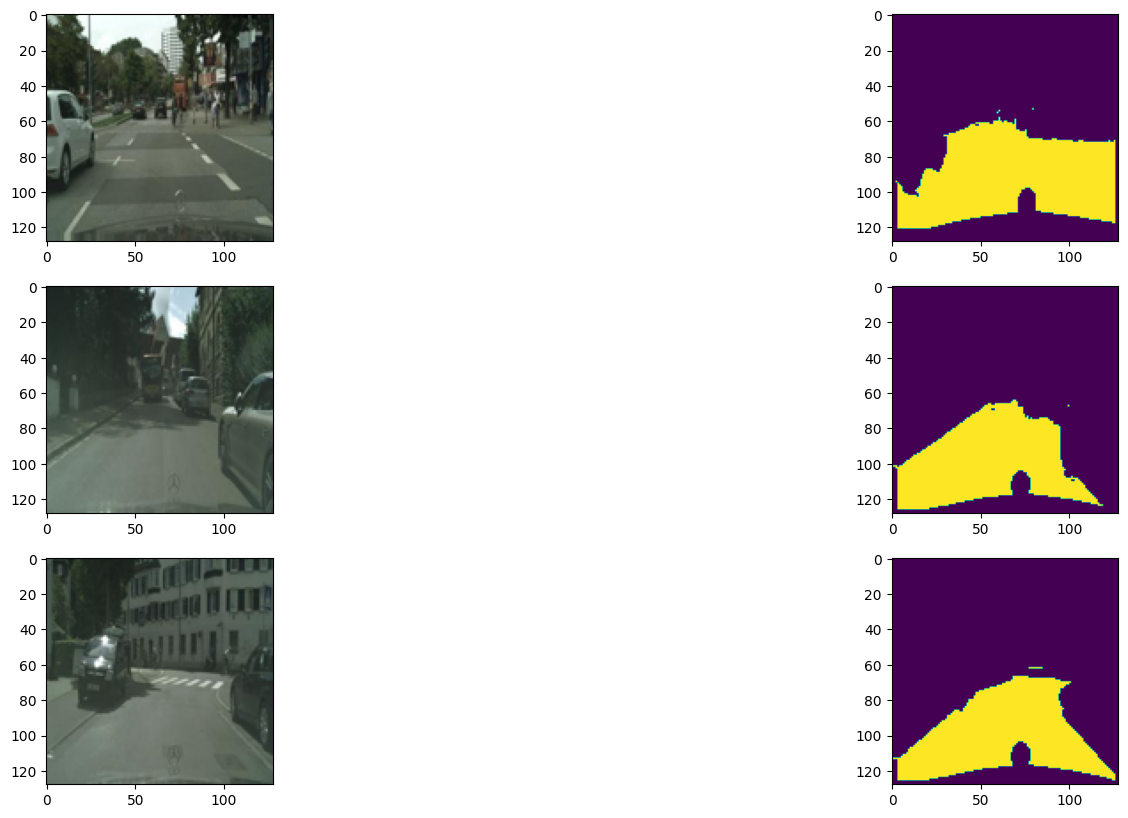

In [142]:

def show_batch(whole_batch, lim = 3):
    images, label = whole_batch[0][:lim], whole_batch[1][:lim]
    images = images.numpy()
    label = label.numpy()
    fig, axs = plt.subplots(lim, 2, figsize = (20, 10))

    for i in range(lim):
        axs[i][0].imshow((images[i]))
        axs[i][1].imshow((label[i]))
show_batch(next(train_loader_iter))


# U-net Model

In [143]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [144]:
import torch
import torch.nn as nn
import torch.nn.functional as functional

In [130]:
'''

    This Module representes the individual horizontal conv block layers in the Unet Model.
    Conv() -> BatchNorm() -> ReLU() -> Conv() -> ReLU()

'''

class Convblock(nn.Module):

      def __init__(self,input_channel,output_channel,kernal=3,stride=1,padding=1):

        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel,output_channel,kernal,stride,padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel,output_channel,kernal),
            nn.ReLU(inplace=True),
        )


      def forward(self,x):
        x = self.convblock(x)
        return x

In [131]:
# Encoder -> BottelNeck => Decoder
class UNet(nn.Module):

    def __init__(self,input_channel,retain=True):

        super().__init__()

        self.conv1 = Convblock(input_channel,32)
        self.conv2 = Convblock(32,64)
        self.conv3 = Convblock(64,128)
        self.conv4 = Convblock(128,256)
        self.neck = nn.Conv2d(256,512,3,1)
        self.upconv4 = nn.ConvTranspose2d(512,256,3,2,0,1)
        self.dconv4 = Convblock(512,256)
        self.upconv3 = nn.ConvTranspose2d(256,128,3,2,0,1)
        self.dconv3 = Convblock(256,128)
        self.upconv2 = nn.ConvTranspose2d(128,64,3,2,0,1)
        self.dconv2 = Convblock(128,64)
        self.upconv1 = nn.ConvTranspose2d(64,32,3,2,0,1)
        self.dconv1 = Convblock(64,32)
        self.out = nn.Conv2d(32,3,1,1)
        self.retain = retain

    def forward(self,x):

        # Encoder Network

        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1,kernel_size=2,stride=2)
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2,kernel_size=2,stride=2)
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3,kernel_size=2,stride=2)
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4,kernel_size=2,stride=2)

        # BottelNeck
        neck = self.neck(pool4)

        # Decoder Network

        # Upconv 1
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4,upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4,croped],1))
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3,upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3,croped],1))
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2,upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2,croped],1))
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1,upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1,croped],1))
        # Output Layer
        out = self.out(dconv1)

        if self.retain == True:
            out = F.interpolate(out,list(x.shape)[2:])

        return out

    def crop(self,input_tensor,target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _,_,H,W = target_tensor.shape
        return transform.CenterCrop([H,W])(input_tensor)


In [132]:
# initializing the model
model = UNet(3).float().to(device)

optimizer = torch.optim.Adam(params = model.parameters(),
                             lr=1e-4)
loss_fn = nn.BCELoss()


In [134]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []

epochs = 10

for i in range(epochs):

    trainloss = 0
    valloss = 0

    for img,label in tqdm(train_loader):
        '''
            Traning the Model.
        '''
        optimizer.zero_grad()
        img = img.float().to(device)
        label = label.float().to(device)
        output = model(img)
        loss = loss_fn(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()

    #if(i%5==0):
    #    show(img,output,label)

    train_loss.append(trainloss/len(train_loader))

    for img,label in tqdm(val_loader):
        '''
            Validation of Model.
        '''
        img = img.float().to(device)
        label = label.float().to(device)
        output = model(img)
        loss = lossfunc(output,label)
        valloss+=loss.item()

    val_loss.append(valloss/len(val_loader))

    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))

  0%|          | 0/268 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[5, 128, 128, 3] to have 3 channels, but got 128 channels instead

In [136]:
img.shape

torch.Size([5, 128, 128, 3])